<a href="https://colab.research.google.com/github/Vmiu/COMP4211FP/blob/main/COMP4211_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/COMP4211_FP"

images_data_zip = os.path.join(data_path,'image_data.zip')

ds_path = "unzipped_data"

Mounted at /content/drive


In [ ]:
!unzip "$images_data_zip" -d unzipped_data> /dev/null 2>&1

In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import random

# Important submodules and functions from Tensorflow (and Keras)
from tensorflow.keras.layers import Input, Dense, Layer, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import array_to_img

from tensorflow.keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import InceptionV3

# Image handling and visualization
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import cv2

# Additional libraries
import seaborn as sn
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from collections import Counter

# Module settings:
# Hide all TensorFlow messages, except for errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Set TensorFlow logger to only output error messages
tf.get_logger().setLevel('ERROR')

## Utility Functions

In [ ]:
def preprocess(x):
    img = tf.reverse(x, axis=[-1])
    # Subtract mean pixel value
    img -= np.array([103.939, 116.779, 123.68])
    return img

# Loads an image from disk, optionally resizes it, and prepares it for the mode
def get_image(img_path, resize=True, shape=(224,224)):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if resize:
        image = cv2.resize(image, shape)
    image = image.astype(np.float32)
    return image

## Dataset

In [ ]:
class ClassificationDataset:
  def __init__(self, dir_path, num_images=1500, batch_size=32, random_state = 4211):
    self.dir_path = dir_path
    self.num_images = num_images
    self.batch_size = batch_size
    self.random_state = random_state
    self.data_table = self._process_dt(dir_path)
    self.ds_pointer = 0
    self.file_path = self.data_table['path'].tolist()
    self.labels = self.data_table['label'].tolist()
    self.one_hot_labels = self.data_table['one_hot_encoder'].tolist()

  def _process_dt(self, dir_path):
    df = pd.DataFrame(columns=["path", "label"])
    model_list = os.listdir(ds_path)
    model_name_list = [model.split('_')[-1] for model in model_list]
    model_path_list = [os.path.join(ds_path, model) for model in model_list]
    data_list = []

    for i in range(len(model_path_list)):
      picture_path = os.path.join(model_path_list[i], 'train/ai')
      picture_path_list = os.listdir(picture_path)[:self.num_images]
      for path in picture_path_list:
          data = {"path": os.path.join(picture_path, path), "label": model_name_list[i]}
          data_list.append(data)

    real_picture_path = os.path.join(model_path_list[0], 'train/nature')
    real_picture_path_list = os.listdir(real_picture_path)[:self.num_images]
    for path in real_picture_path_list:
          data = {"path": os.path.join(real_picture_path, path), "label": "nature"}
          data_list.append(data)

    df = pd.DataFrame(data_list)

    label_class = sorted(df['label'].unique())
    label_with_index = {label: index for index, label in enumerate(label_class)}
    # Create a one-hot encoded matrix for the labels
    onehot_label = np.zeros((len(df), len(label_class)), dtype=np.float32)
    for i, label in enumerate(df['label']):
        onehot_label[i, label_with_index[label]] = 1.0
    df['one_hot_encoder'] = onehot_label.tolist()

    return df

  def reset_pointer(self, seed=None):
    self.ds_pointer = 0
    if seed is not None:
      self.random_state = seed
    self.data_table = self.data_table.sample(frac = 1, random_state = self.random_state)
    self.data_table = self.data_table.reset_index(drop = True)
    self.file_path = self.data_table['path'].tolist()
    self.labels = self.data_table['label'].tolist()
    self.one_hot_labels = self.data_table['one_hot_encoder'].tolist()

  def get_batch(self,VGG=False):
    batch_image = []
    batch_label = []
    if self.ds_pointer + self.batch_size > len(self.file_path):
      self.reset_pointer()
    for i in range(self.batch_size):
      image_path = self.file_path[self.ds_pointer]
      image = get_image(image_path)
      if VGG == True:
        image = preprocess(image)
      batch_image.append(image)
      batch_label.append(self.one_hot_labels[self.ds_pointer])
      self.ds_pointer += 1
    return np.array(batch_image),np.array(batch_label)

  def train_test_split(self, test_size):
    train_df, test_df = train_test_split(self.data_table, test_size=test_size, random_state=self.random_state)

    train_ds = ClassificationDataset(dir_path=self.dir_path, num_images=len(train_df), batch_size=self.batch_size, random_state=self.random_state)
    train_ds.data_table = train_df
    train_ds.file_path = train_df['path'].tolist()
    train_ds.labels = train_df['label'].tolist()
    train_ds.one_hot_labels = train_df['one_hot_encoder'].tolist()

    test_ds = ClassificationDataset(dir_path=self.dir_path, num_images=len(test_df), batch_size=self.batch_size, random_state=self.random_state)
    test_ds.data_table = test_df
    test_ds.file_path = test_df['path'].tolist()
    test_ds.labels = test_df['label'].tolist()
    test_ds.one_hot_labels = test_df['one_hot_encoder'].tolist()

    return train_ds, test_ds

  def show(self):
    label_dict = {}
    for i in range(len(self.file_path)):
      label = self.labels[i]
      if label in label_dict:
        label_dict[label]+=1
      else:
        label_dict[label]=1
    sorted_dict = dict(sorted(label_dict.items()))
    return sorted_dict

  def __len__(self):
    return len(self.file_path)

In [ ]:
ds = ClassificationDataset(ds_path)

In [ ]:
print(f"dataset length: {len(ds)}")
num_class = len(ds.data_table['label'].unique())
print(f"num_class : {num_class}")

dataset length: 12000
num_class : 8


In [ ]:
image_batch, label_batch = ds.get_batch()
print(image_batch[0].shape)

(224, 224, 3)


In [ ]:
train_ds, test_ds = ds.train_test_split(test_size=0.2)
print(f"len of train ds = {len(train_ds)}")
print(f"len of test ds = {len(test_ds)}")

len of train ds = 9600
len of test ds = 2400


In [ ]:
print("train dataset")
train_ds.show()

train dataset


{'adm': 1201,
 'biggan': 1198,
 'glide': 1210,
 'midjourney': 1191,
 'nature': 1217,
 'sdv5': 1186,
 'vqdm': 1213,
 'wukong': 1184}

In [ ]:
print("test dataset")
test_ds.show()

test dataset


{'adm': 299,
 'biggan': 302,
 'glide': 290,
 'midjourney': 309,
 'nature': 283,
 'sdv5': 314,
 'vqdm': 287,
 'wukong': 316}

## Data Visualization


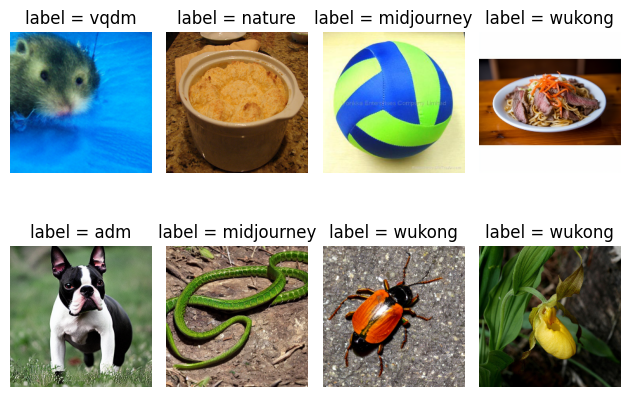

In [ ]:
adetrain_ds.reset_pointer()
index = train_ds.ds_pointer
batch_image, batch_label= train_ds.get_batch()
label_class = sorted(train_ds.data_table['label'].unique())
rows = 2
cols = 4
fig, axes = plt.subplots(rows, cols)
for i in range(8):
    index += i
    image = array_to_img(batch_image[i])
    row = i // cols
    col = i % cols
    # Display the image in the appropriate subplot
    axes[row, col].imshow(image)
    label_index = np.argmax(batch_label[index])
    axes[row, col].set_title("label = ",label_class[label_index])
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Model Training


In [ ]:
def model_train(model, dataset, loss_fn, n_epochs = 10, save_interval = 5, VGG = False, save_path=None, load_path=None):
  # Initialize the Optimizer
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,weight_decay=5e-5)

  # Calculate the number of batches per epoch
  n_batches = len(dataset)//dataset.batch_size

  # Initialize other things
  process = psutil.Process(os.getpid())

  # Load weights if provided
  if load_path:
    model.load_weights(load_path)

  # Run for n epochs
  for e in range(1, n_epochs+1):
    pbar = tqdm(total=n_batches)
    # Reset Dataset Iterators
    dataset.reset_pointer()
    loss_list = []

    # Define Loss Metrics. To be updated in each batch
    losses = {"cross-entropy": 0.0}

    # Run for all batches
    for i in range(n_batches):
      # Fetch Training Batches
      if VGG == True:
        batch,label = dataset.get_batch(VGG=True)
      else:
        batch,label= dataset.get_batch()

      # Execute Batch Training
      with tf.GradientTape() as tape:
          out = model(batch)
          loss = loss_fn(label,out)
      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))

      # Update Loss Metrics
      loss_list.append(loss)
      losses["cross-entropy"] = sum(loss_list)/len(loss_list)

      # Visualize loss during training
      string = "".join([f"{key} loss: {value:.3f}\t" for key, value in losses.items()])
      pbar.set_description(f"Epoch {e}/{n_epochs}\t" + string)
      pbar.update(1)

    # In case the session ends before the training is done, perform save the model from time to time:
    if e % save_interval == 0:
        if save_path:
            model.save(save_path)

In [ ]:
def Model_evaluate(model, dataset, label_mapping):
    n_batches = len(dataset)//dataset.batch_size
    acc_list = []
    num_class = len(train_ds.data_table['label'].unique())
    cm = np.zeros((num_class,num_class))
    dataset.reset_pointer()
    for i in range(n_batches):
        batch,label = dataset.get_batch()
        out = model.predict(batch, verbose=False)
        y_pred = np.argmax(out, axis=1)
        y_true = np.argmax(label, axis=1)
        acc = np.mean(y_true == y_pred)
        acc_list.append(acc)
        cm += confusion_matrix(y_true, y_pred, labels=np.arange(num_class))
    accuracy = sum(acc_list)/len(acc_list)
    print(f"Accuracy:{accuracy}")
    # Convert the integer labels to string labels
    string_labels = [label_mapping[i] for i in range(num_class)]
    sn.heatmap(cm, annot=True, xticklabels=string_labels, yticklabels=string_labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
label_class = sorted(ds.data_table['label'].unique())

## Model: VGG19

In [ ]:
# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, pooling = 'max', input_shape=(224, 224, 3))

# Freeze the base model trainable weight
for layer in base_model.layers:
    layer.trainable = False

# Create the final model
VGG_model = Sequential(name='VGG19')
VGG_model.add(base_model)
VGG_model.add(Flatten())
VGG_model.add(BatchNormalization())
VGG_model.add(Dense(1024, activation='gelu', name='dense1'))
VGG_model.add(Dropout(0.3))
VGG_model.add(BatchNormalization())
VGG_model.add(Dense(512, activation='gelu', name='dense2'))
VGG_model.add(Dense(512, activation='gelu', name='dense3'))
VGG_model.add(Dropout(0.3))
VGG_model.add(BatchNormalization())
VGG_model.add(Dense(256, activation='gelu', name='dense4'))
VGG_model.add(Dense(num_class, activation='softmax', name='output'))
VGG_model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense1 (Dense)              (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096   

In [ ]:
VGG_LOAD_PATH = "/content/drive/MyDrive/Project_VGG_gelu.h5"
VGG_model.load_weights(VGG_LOAD_PATH)

30 epochs


In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
VGG_SAVE_PATH = "/content/drive/MyDrive/Project_VGG_gelu.h5"
model_train(VGG_model,train_ds,loss_fn,VGG=True,save_path=VGG_SAVE_PATH)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy:0.45708333333333334


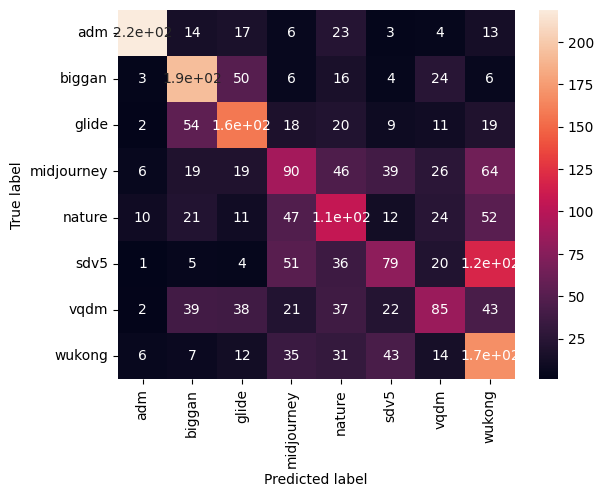

In [ ]:
Model_evaluate(VGG_model, test_ds,label_class)

## Model: Resnet50

In [ ]:
# Load the pre-trained ResNet50 model
base_model = ResNet50V2(weights='imagenet', include_top=False, pooling = 'avg', input_shape=(224, 224, 3))

# Freeze the base model trainable weight
for layer in base_model.layers:
    layer.trainable = False

# Create the final model
ResNet_model = Sequential(name='ResNet50')
ResNet_model.add(base_model)
ResNet_model.add(Flatten())
ResNet_model.add(BatchNormalization())
ResNet_model.add(Dense(1024, activation='gelu', name='dense1'))
ResNet_model.add(Dropout(0.3))
ResNet_model.add(BatchNormalization())
ResNet_model.add(Dense(512, activation='gelu', name='dense2'))
ResNet_model.add(Dense(512, activation='gelu', name='dense3'))
ResNet_model.add(Dropout(0.3))
ResNet_model.add(BatchNormalization())
ResNet_model.add(Dense(256, activation='gelu', name='dense4'))
ResNet_model.add(Dense(num_class, activation='softmax', name='output'))
ResNet_model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_3 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense1 (Dense)              (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 batch_normalization_4 (Bat  (None, 1024)              4096

In [ ]:
ResNet50_LOAD_PATH = "/content/drive/MyDrive/COMP4211_FP/Project_ResNet50_4dense.h5"
ResNet_model.load_weights(ResNet50_LOAD_PATH)

30 epochs

In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
ResNet50_SAVE_PATH = "/content/drive/MyDrive/Project_ResNet50_gelu.h5"
model_train(ResNet_model,train_ds,loss_fn,save_path=ResNet50_SAVE_PATH)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy:0.5458333333333333


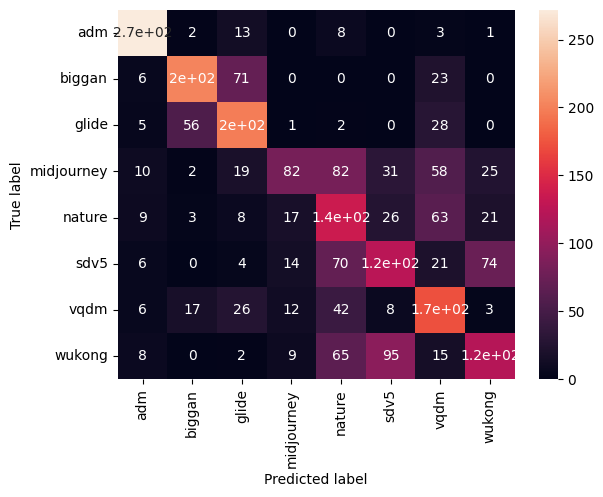

In [ ]:
Model_evaluate(ResNet_model, test_ds,label_class)

# Combination of multiple models

Given the low accuracy of tradition model, we realize that the capabilities of a single model may not be sufficient to solve this challenge.
XGBoost is known for its high prediction accuracy and performance, but it does not perform the same kind of deep feature learning that deep learning models like CNNs are known for. Considering the pros and cons for different models, we try out the combination of CNN/Resnet/InceptionV3 + RandomForest/SupportVectorMachine, which uses the former model to generate features and use the latter model to classify the pictures.

In [ ]:
# Retrieve data for train and test

model_list = os.listdir(ds_path)
model_name_list = [model.split('_')[-1] for model in model_list]
model_path_list = [os.path.join(ds_path, model) for model in model_list]
image_paths = []
labels = []
num_images = 800

for i in range(len(model_path_list)):
    picture_path = os.path.join(model_path_list[i], 'train/ai')
    picture_path_list = os.listdir(picture_path)[:num_images]
    for path in picture_path_list:
        image_paths.append(os.path.join(picture_path, path))
        labels.append(model_name_list[i])

real_picture_path = os.path.join(model_path_list[0], 'train/nature')
real_picture_path_list = os.listdir(real_picture_path)[:num_images]
for path in real_picture_path_list:
    image_paths.append(os.path.join(real_picture_path, path))
    labels.append("nature")

def retrieve_image(path):
  img = image.load_img(path, target_size=(224, 224))
  img = preprocess(img)
  return img

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.3, random_state=4211)

In [ ]:
def print_unique_values(list):
    counter = Counter(list)
    for value, count in counter.items():
        print("value", ":", "count")

print("y_train:")
print_unique_values(y_train)
print("y_test:")
print_unique_values(y_test)

y_train:
midjourney: 557
glide: 557
biggan: 586
vqdm: 538
adm: 565
nature: 561
sdv5: 545
wukong: 571
y_test:
wukong: 229
vqdm: 262
midjourney: 243
biggan: 214
sdv5: 255
nature: 239
glide: 243
adm: 235


In [ ]:
# Use base models as feature extractors
base_model_vgg19 = VGG19(weights='imagenet', include_top=False , input_shape=(224, 224, 3))
base_model_inception = InceptionV3(weights='imagenet' , include_top=False, input_shape=(224, 224, 3))
base_model_resnet = ResNet50(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

def extract_features(image_paths, base_model):
    features = []
    for image_path in image_paths:
        image_ret = image.load_img(image_path, target_size=(224, 224))
        image_ret = image.img_to_array(image_ret)
        image_ret = preprocess_input(image_ret)
        image_ret = np.expand_dims(image_ret, axis=0)
        feature = base_model.predict(image_ret,verbose=False)
        features.append(feature.flatten())
    return np.array(features)

def show_result(y_test, prediction):
  accuracy = accuracy_score(y_test, prediction)
  print("Accuracy:", accuracy*100, "%")
  confusion_matrix = confusion_matrix(y_test, prediction)
  string_labels = []
  for i in range(len(model_name_list)):
    string_labels.append(model_name_list[i])
  sn.heatmap(confusion_matrix, annot=True, xticklabels=string_labels, yticklabels=string_labels)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.show()

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Prepare the corresponding x_train and x_test
features_train_vgg19 = extract_features(x_train, base_model_vgg19)
features_test_vgg19 = extract_features(x_test, base_model_vgg19)
features_train_inception = extract_features(x_train, base_model_inception)
features_test_inception = extract_features(x_test, base_model_inception)
features_train_resnet = extract_features(x_train, base_model_resnet)
features_test_resnet = extract_features(x_test, base_model_resnet)

KeyboardInterrupt: 

# VGG19 + Random Forest


Accuracy: 54.83%


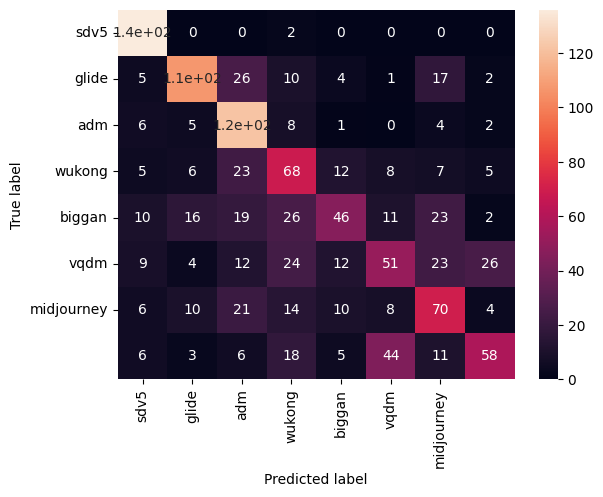

In [ ]:
random_forest = RandomForestClassifier(n_estimators=1000, random_state=4211)
random_forest.fit(features_train_vgg19.reshape(features_train_vgg19.shape[0], -1), y_train)
predictions_vgg_rf = random_forest.predict(features_test_vgg19.reshape(features_test_vgg19.shape[0], -1))

show_result(y_test, predictions_vgg_rf)

## VGG19 + Support Vector Machine

Accuracy: 51.67%


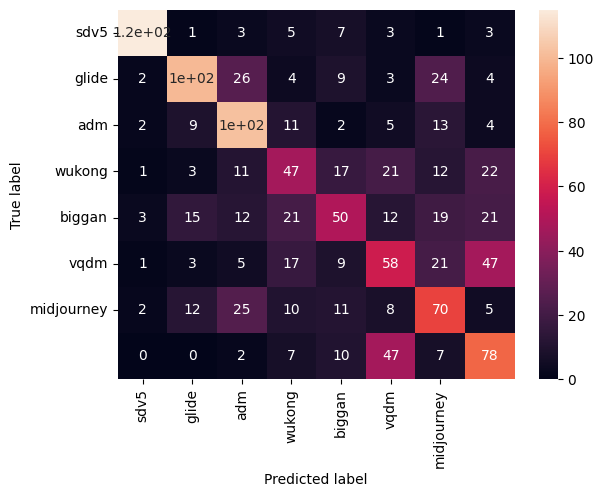

In [ ]:
svm_classifier = SVC()
svm_classifier.fit(features_train_vgg19.reshape(features_train_vgg19.shape[0], -1), y_train)
predictions_vgg_svm = svm_classifier.predict(features_test_vgg19.reshape(features_test_vgg19.shape[0], -1))

show_result(y_test, predictions_vgg_svm)

## Inception V3 + Random Forest

Accuracy: 25.83%


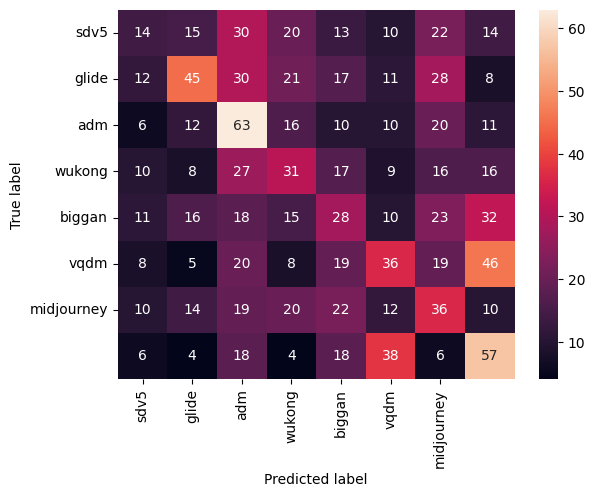

In [ ]:
random_forest = RandomForestClassifier(n_estimators=1000, random_state=4211)
random_forest.fit(features_train_inception.reshape(features_train_inception.shape[0], -1), y_train)
predictions_inc_rf = random_forest.predict(features_test_inception.reshape(features_test_inception.shape[0], -1))

show_result(y_test, predictions_inc_rf)

## Inception V3 + Support Vector Machine

Accuracy: 27.17%


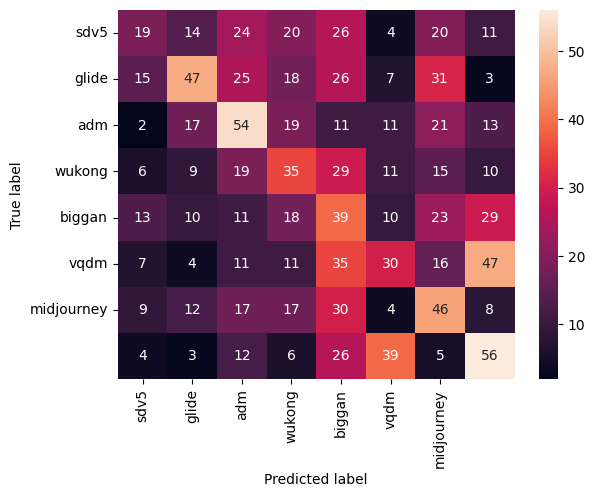

In [ ]:
svm_classifier = SVC()
svm_classifier.fit(features_train_inception.reshape(features_train_inception.shape[0], -1), y_train)
predictions_inc_svm = svm_classifier.predict(features_test_inception.reshape(features_test_inception.shape[0], -1))

show_result(y_test, predictions_inc_svm)

## ResNet + Random Forest

Accuracy: 62.33%


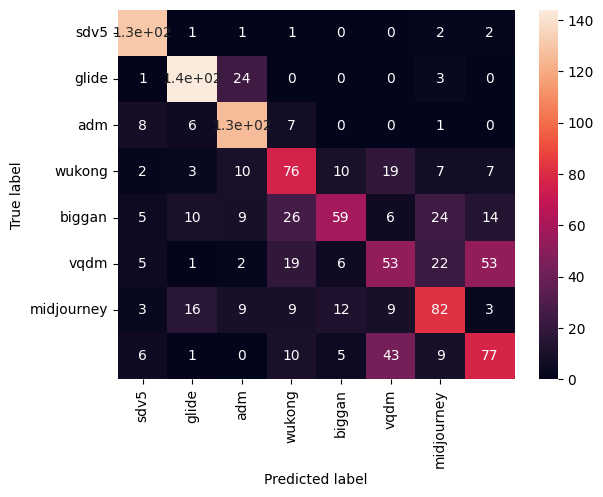

In [ ]:
random_forest = RandomForestClassifier(n_estimators=1000, random_state=4211)
random_forest.fit(features_train_resnet.reshape(features_train_resnet.shape[0], -1), y_train)
predictions_res_rf = random_forest.predict(features_test_resnet.reshape(features_test_resnet.shape[0], -1))

show_result(y_test, predictions_res_rf)

## ResNet + Support Vector Machine

Accuracy: 59.50%


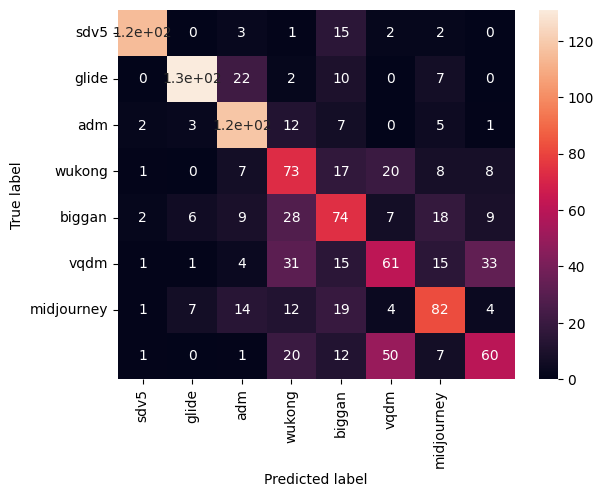

In [ ]:
svm_classifier = SVC()
svm_classifier.fit(features_train_resnet.reshape(features_train_resnet.shape[0], -1), y_train)
predictions_res_svm = svm_classifier.predict(features_test_resnet.reshape(features_test_resnet.shape[0], -1))

show_result(y_test, predictions_res_svm)

Accuracy: 54.92%


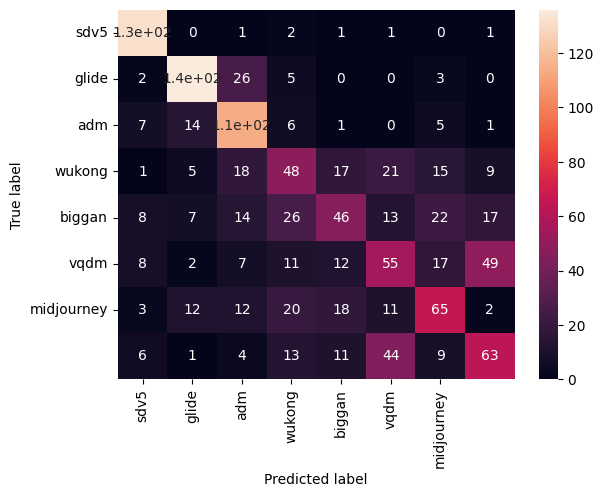

In [ ]:
# Combine the extracted features
combined_features_train = np.concatenate((features_train_vgg19, features_train_inception, features_train_resnet), axis=1)
combined_features_test = np.concatenate((features_test_vgg19, features_test_inception, features_test_resnet), axis=1)

# Train Random Forest classifier on combined features
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(combined_features_train, y_train)

# Make predictions on the test set
predictions_combined_rf = random_forest_classifier.predict(combined_features_test)
show_result(y_test, predictions_combined_rf)